In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [3]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

* VAE有兩大重點：1.神經網路裡面可以加入抽樣 2.進行重參數化

In [20]:
enc_1 = Dense(200, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(200, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [21]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [22]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [23]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [24]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [25]:
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 200)          157000      input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            402         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            402         dense_5[0][0]                    
____________________________________________________________________________________________

In [26]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [27]:
VAE.compile(loss='MAE',
                    optimizer=Adam(3e-4),
                    metrics=['mse'])

# VAE.load_weights('VAE_handwriting_model_weights.h5')

In [28]:
VAE.fit(X_train, X_train, 
        batch_size=256, 
        epochs=20)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 78us/sample - loss: 70.9879 - mse: 0.0901s - ETA: 1s -
Epoch 2/20
60000/60000 [==============================] - 4s 59us/sample - loss: 53.6003 - mse: 0.0679
Epoch 3/20
60000/60000 [==============================] - 3s 56us/sample - loss: 51.9125 - mse: 0.0649
Epoch 4/20
60000/60000 [==============================] - 4s 59us/sample - loss: 50.4603 - mse: 0.0626
Epoch 5/20
60000/60000 [==============================] - 3s 53us/sample - loss: 50.0696 - mse: 0.0621
Epoch 6/20
60000/60000 [==============================] - 3s 53us/sample - loss: 49.8508 - mse: 0.0617
Epoch 7/20
60000/60000 [==============================] - 3s 53us/sample - loss: 49.0962 - mse: 0.0602
Epoch 8/20
60000/60000 [==============================] - 3s 55us/sample - loss: 47.7654 - mse: 0.0580
Epoch 9/20
60000/60000 [==============================] - 3s 55us/sample - loss: 47.2830 - mse: 0.0574
Epoch 10/20
60000/60000 [============

In [32]:
VAE.save_weights('VAE_model_weights3.h5')

In [29]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 157,402
Trainable params: 157,402
Non-trainable params: 0
_________________________________________________________________


In [30]:
VAE_Decoder = Model(z_input, dec_1(dec_2(z_input)))

VAE_Decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               157584    
Total params: 158,184
Trainable params: 158,184
Non-trainable params: 0
_________________________________________________________________


In [31]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")


第 53200 圖的 latent 表示為 [0.02464623 1.0090394 ]


In [32]:
indice = np.random.randint(X_train.shape[0],size=5000)

In [33]:
VAE_Encoder.predict(X_train[indice])

array([[ 0.64078254,  0.5625024 ],
       [-1.2701951 ,  1.2774186 ],
       [ 1.0799713 , -0.07509249],
       ...,
       [-0.98727316,  1.9691249 ],
       [ 0.95404243,  1.9338336 ],
       [ 0.23984538,  0.46045232]], dtype=float32)

In [34]:
VAE_latents = VAE_Encoder.predict(X_train[indice])

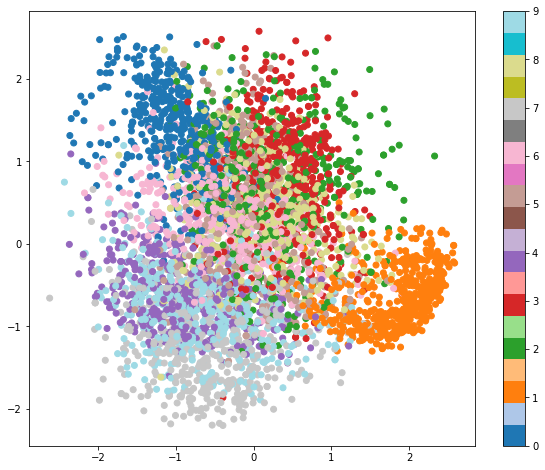

In [35]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indice], cmap='tab20')
plt.colorbar()
plt.show()

In [92]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x